In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

#Exibição na mesma tela do Jupyter
%matplotlib inline

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

#from keras.utils import np_utils

/Users/michel.fernandes/anaconda/lib/python3.6/site-packages/joblib/_multiprocessing_helpers.py:28: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
Using TensorFlow backend.


Para criar um modelo de Deep Learning para reconhecimento de caracteres, vamos utilizar a base conhecida chamada [MNIST](http://yann.lecun.com/exdb/mnist/).

Neste exemplo, vamos utilizar somente a base numérica e classificar dígito a dígito, deste modo o número de classes que teremos será 10, isto é de 0 a 9.

Adaptado deste [artigo](https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d) de Orhan Gazi Yalçın.

In [2]:
total_classes = 10

Afim de ganharmos tempo, vamos utilizar um biblioteca do Keras que já faz o donwload do dataset e deixa pronto para o uso.

In [3]:
# Download da base do MINST
# Serão 60.000 imagens de treino e 10.000 de teste

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Note o shape esperado, se tratando de imagens em grayscale não há 
print("Imagens de treino (X) 28 x 28", x_train.shape)
print("Classes de treino (y)", y_train.shape)

print("Imagens de teste (X) 28 x 28", x_test.shape)
print("Classes de treino (y)", y_test.shape)

Imagens de treino (X) 28 x 28 (60000, 28, 28)
Classes de treino (y) (60000,)
Imagens de teste (X) 28 x 28 (10000, 28, 28)
Classes de treino (y) (10000,)


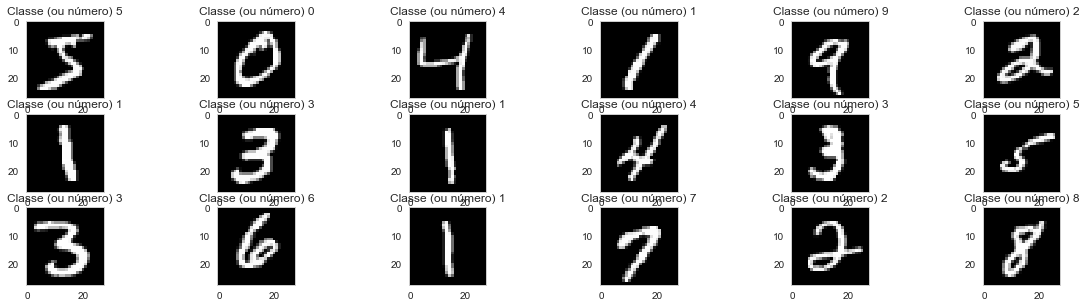

In [10]:
plt.figure(figsize=(20,10))

for i in range(18):
    plt.subplot(6,6,i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title("Classe (ou número) {}".format(y_train[i]))

O Keras trabalha com uma forma diferente dos dados. Ao invés de utilizar as 3 dimensões, precisaremos de mais uma dimensão para incluir as imagens que farão parte dos treinamentos e testes, obtendo **Número de Imagens, Comprimento, Largura, Canal Normalizado**.

In [11]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print("Imagens de treino (x) 28 x 28:", x_train.shape)
print("Quantidade de imagens de treino: ", x_train.shape[0])
print("Quantidade de imagens de treino", x_test.shape[0])

Imagens de treino (x) 28 x 28: (60000, 28, 28, 1)
Quantidade de imagens de treino:  60000
Quantidade de imagens de teste 10000


Vamos também simplificar a informação de escala de cinza. Utilizaremos a forma normalizada, dividindo todos os valores por 255. Desta forma um pixel 100% branco seria 1, e outro 100% preto seria 0.

In [12]:
# Convetendo os valores para float para lidarmos com os valores normalizados
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizando os dados pelo valor máximo de pixel
x_train /= 255
x_test /= 255

print('Imagens de treino (x) 28 x 28:', x_train.shape)
print('Quantidade de imagens de treino', x_train.shape[0])
print('Quantidade de imagens de treino', x_test.shape[0])

Imagens de treino (x) 28 x 28: (60000, 28, 28, 1)
Quantidade de imagens de treino 60000
Quantidade de imagens de treino 10000


Agora vamos definir a entrada dos dados, neste caso precisa ser exatamente da mesma forma que as imagens forem treinadas. Isso é portante pois a rede neural estará preparada para inferir somente imagens com este tamanho.

In [ ]:
shape_entrada = (28, 28, 1)

Abaixo vamos constuir um modelo simples, do zero. Como as imagens são bem simples, diversas arquiteturas funcionam.

Quando lidamos com objetos mais complexos, é bem comum optarmos por arquiteturas abertas como por exemplo:

*[VGG](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) de Oxford
*[ResNet](https://arxiv.org/abs/1512.03385) da Microsoft
*[Inception](https://github.com/google/inception) do Google
*[Xception](https://arxiv.org/abs/1610.02357) do Google

Depois de avaliar estas arquiteturas, é possível adapta-las para classificar imagens específicas, isso se dá alterando as últimas camadas. É o que chamamos também de **Transfer Learning**.

Neste [link](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5) você pode encontrar mais sobre outras arquiteturas.

In [42]:
# Construindo um modelo sequencial
model = Sequential()

# Este componente, se trata de um filtro ou uma camada convulacional. Ela será responsável por 
# colocar uma janela de kernel (3x3), navegar pela imagem e extrair a soma dos pixels de cada janela
# o passo para mover a janela, chamado Stride, por padrão é de um pixel
model.add(Conv2D(28, kernel_size=(3,3), input_shape=shape_entrada))

# A camada de Pooling (ou MaxPooling2D) tem o papel de reduzir a dimensionalidade. Neste caso, a partir 
# da etapa anterior, será dividia em grupos de 2 x 2 pixels e será obtida o maior valor deles
model.add(MaxPooling2D(pool_size=(2,2)))

# Esta etapa conhecida como "achatamento" é onde abrimos os dados organizados em tabelas (ou matrizes) 
# par auma única linha
model.add(Flatten())

# A camada densa (ou Dense) conectará cada elemento da camada anterior e passará para a próxima
# camada com as classes existentes
model.add(Dense(128, activation="relu"))

# O Dropout é um ruído gerado para evitar overfitting
model.add(Dropout(0.2))

# A camada final, determinará qual classe escolher. Por tal razão ela possui a ativação Softmax, que retorna 
# a probabilidade por classe
model.add(Dense(10,activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 28)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 4732)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               605824    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 10)                1290      
Total params: 607,394
Trainable params: 607,394
Non-trainable params: 0
_________________________________________________________________


Para revisão de funções de ativação, em particular [Relu](https://matheusfacure.github.io/2017/07/12/activ-func/).

In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 56s 938us/step - loss: 0.2124 - acc: 0.9360
Epoch 2/10
60000/60000 [==============================] - 51s 851us/step - loss: 0.0858 - acc: 0.9735
Epoch 3/10
60000/60000 [==============================] - 52s 864us/step - loss: 0.0599 - acc: 0.9809
Epoch 4/10
60000/60000 [==============================] - 52s 865us/step - loss: 0.0438 - acc: 0.9858
Epoch 5/10
60000/60000 [==============================] - 54s 899us/step - loss: 0.0358 - acc: 0.9882
Epoch 6/10
60000/60000 [==============================] - 54s 906us/step - loss: 0.0287 - acc: 0.9905
Epoch 7/10
60000/60000 [==============================] - 53s 879us/step - loss: 0.0242 - acc: 0.9919
Epoch 8/10
60000/60000 [==============================] - 52s 870us/step - loss: 0.0222 - acc: 0.9922
Epoch 9/10
60000/60000 [==============================] - 52s 868us/step - loss: 0.0187 - acc: 0.9937
Epoch 10/10
60000/60000 [==============================] - 51s 854us/step - loss: 

Salvando o modelo para uso posterior. Mesmo imagens pequenas como essas levam vários minutos para treinar.

In [18]:
# Salvando o modelo no formato HDf5
model.save("modelos/model.h5")

# Arquitetura das camadas em JSSON e pesos treinados em HDF5
model.save_weights("pesos/weights.h5")

Uma vez salvo o modelo, nesta etapa é só carregar.

In [15]:
# carregando o modelo no formato HDf5
model = load_model("modelos/model.h5")  
model.load_weights("pesos/weights.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4732)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               605824    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 607,394
Trainable params: 607,394
Non-trainable params: 0
_________________________________________________________________


In [16]:
score = model.evaluate(x_test, y_test)

print('Perda (teste):', score[0])
print('Acurácia (teste):', score[1])

print(model.metrics_names)

10000/10000 [==============================] - 4s 368us/step
Perda (teste): 0.05667663485010635
Acurácia (teste): 0.9861
['loss', 'acc']


Vamos inferir algumas imagens para verificar visualmente como o classificador está se comportando.

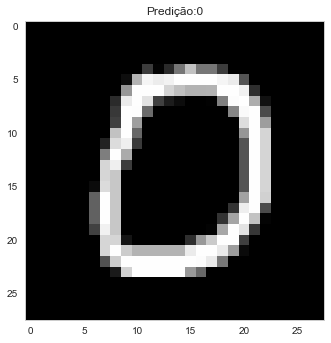

In [23]:
image_index = 10

pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
plt.title("Predição:" + str(pred.argmax()))
plt.imshow(x_test[image_index].reshape(28, 28),cmap='gray')

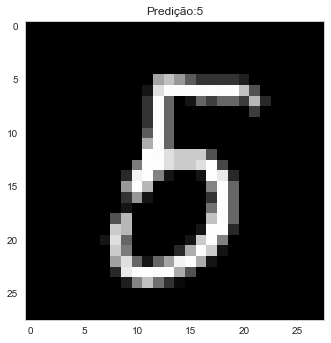

In [24]:
image_index = 45

pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
plt.title("Predição:" + str(pred.argmax()))
plt.imshow(x_test[image_index].reshape(28, 28),cmap='gray')

In [25]:
x_test[image_index].shape

(28, 28, 1)